In [1]:
import numpy as np
from music21 import *
import pandas as pd
from matplotlib import pyplot as plt

import sounddevice as sd
from scipy.io.wavfile import write

In [2]:
#generate dataset
duration = 10
#X sampling interval
interval = 100

#specify the X-range (time dimension) as a vector
X_v = np.arange(0, duration, duration/interval)

In [3]:
#generate the frequencies to sample.
#specify range between musical notes C3 and C5
f_low =  65.41 #C3
f_high = 523.25 #C5

#number of frequency samples
freq_samp = 500

#space frequencies on a log scale 
Y_v = np.logspace(np.log10(f_low),np.log10(f_high),num=freq_samp,endpoint=True, base=10.0)

In [4]:
#generate the amplitude data from 3D data or a 3D equation
X, Y = np.meshgrid(X_v, Y_v)
R = np.sqrt(X**2 + (Y/100)**2)
#amplitude
Z = np.sin(R)+1

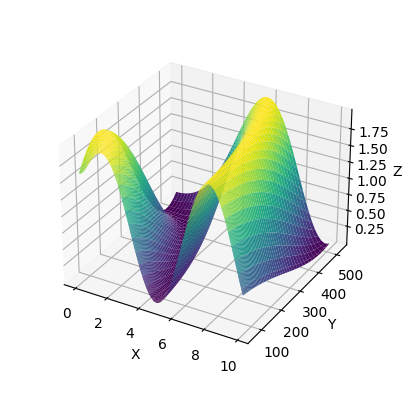

In [5]:
#Visualize the surface plot
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect(None, zoom=0.85)

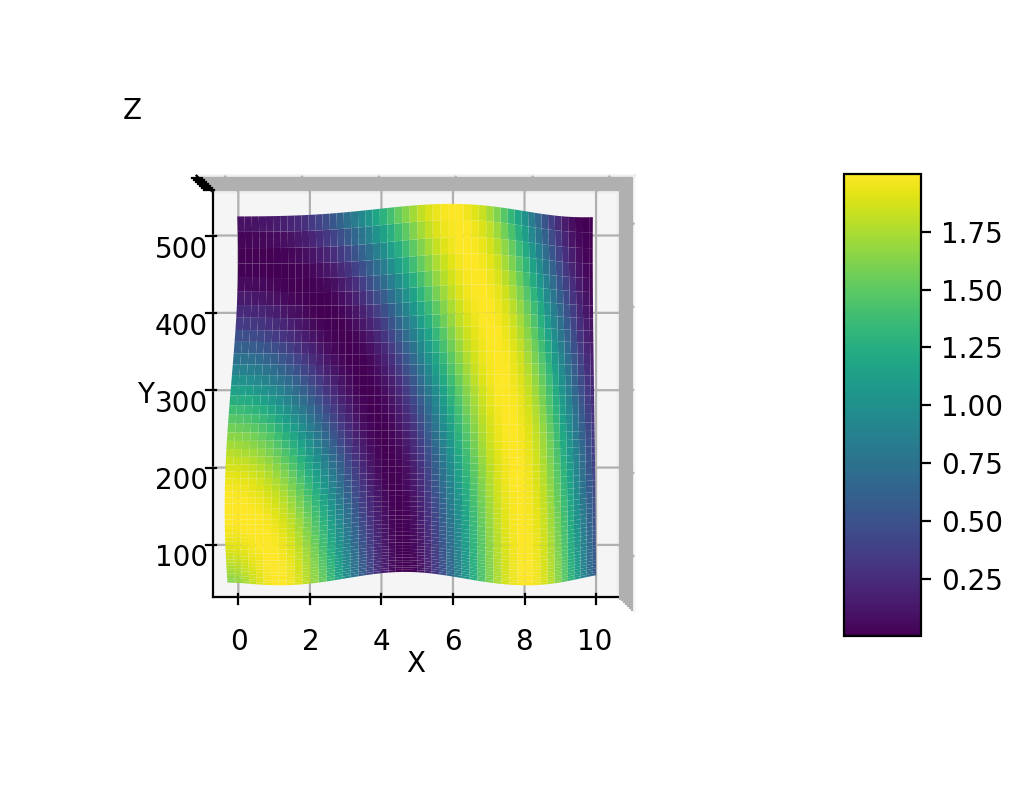

In [22]:
#Visualize the surface plot
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=90, azim=-90) 
ax.set_box_aspect(None, zoom=0.85)
ax.set(zticklabels=[])
fig.colorbar(surf, shrink=0.6, aspect=6)

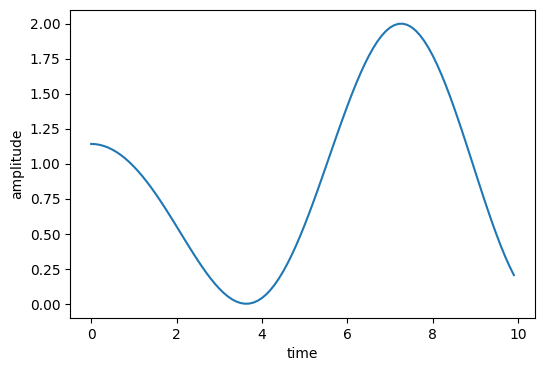

In [7]:
#visualize the amplitude vs time for a slice at a single frequency
X_slice = np.arange(0, 10, 10/100)
Y_slice = 300
R = np.sqrt(X_slice**2 + (Y_slice/100)**2)
Z_slice = np.sin(R)+1

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

# Plot the surface
ax.plot(X_slice, Z_slice)
ax.set_xlabel("time")
ax.set_ylabel("amplitude")


In [ ]:
#Visualize the waveform generated from a sine wave for a signel frequency, combining the amplitudes with the sine-curve
#time
X_slice = np.arange(0, 10, 10/100000)
#frequency
Y_slice = 300
#amplitude
R = np.sqrt(X_slice**2 + (Y_slice/100)**2)
Z_slice = (np.sin(R)+1)*(np.sin(2*np.pi*X_slice*Y_slice))

fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
#plot time-dependent wave for the specified frequency
ax.plot(X_slice, Z_slice)
ax.set_xlabel("time")
ax.set_ylabel("amplitude")

In [ ]:
# combine multiple single-frequency waveforms to generate the total wave

# Sampling rate- samples per second
fs = 44100

# determine the total numer of samples from the duration of the composition and the sampling rate
t = np.linspace(0, duration, int(fs * duration), False)

#determine the number of samples in each interval in the original Z-dataset
l_data = len(Z[0])
t_step = int(np.floor(int(fs * duration)/l_data))


#build a vector that lists the amplitudes at each time interval with the shorter sampling interval
A_length = len(Z[0])*t_step

#fill the sampling data in between the original Z-data points by interpolating the values
#do this for the first row in the dataset by selecting Z[0]
A_ind = np.linspace(0, len(Z[0]) - 1, A_length)
A = np.interp(A_ind, np.arange(len(Z[0])), Z[0])
zeros = np.zeros(len(t)-len(A))
A_2 = np.append(A, zeros)

#initialize the combined waveform (notes) with the sine wave equation for the initial frequency freqs[0]
notes = A_2*np.sin(Y_v[0] * t * 2 * np.pi)

#repeat above steps for each of the rows in the Z matrix representing each frequency played
for i in range(len(Z)-1):
    A_length = len(Z[i])*t_step
    A_ind = np.linspace(0, len(Z[i]) - 1, A_length)
    A = np.interp(A_ind, np.arange(len(Z[i])), Z[i])
    A_2 = np.append(A, zeros)
    note = A_2*np.sin(Y_v[i] * t * 2 * np.pi)
    notes = notes + note
             
# scale to the maximum value for an int16 NumPy data type to export as a 16 bit PCM wavefile
# (https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html)
notes *= 32767 / np.max(np.abs(notes))

# Convert to 16-bit data
notes = notes.astype(np.int16)


In [ ]:
#visualize the combined waveform
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(t,notes)
plt.xlim([5,6])
plt.ylim([-5000,5000])
ax.set_xlabel("time")
ax.set_ylabel("amplitude")

In [ ]:
#play sound and export as wave file
sd.play(notes, samplerate=fs)

write('data_sounds_29_Dec.wav', fs, notes)